In [1]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
#image_folder = r"C:\Users\danie\Desktop\just one photo"
#image_pathway = r"C:\Users\danie\Desktop\just one photo\13.jpg"

single_image = ""

TOO_SMALL = 2000
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 1024
width = 1024

epochs = 10 
batch_size = 1 
total_images = 1

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import TensorBoard

In [3]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [4]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg')

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [5]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [6]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [7]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB1:', np.min(Y_LAB1), np.max(Y_LAB1))
    Y_LAB = Y_LAB1 / 128
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [30]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [31]:
PCA_YN = "no"

prep_image(single_image)

#df = create_dataframe(image_folder)
#prep_dataframe(df)

processing 2 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
750
600
(750, 600, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 1.1137498506471282 100.0
Y_LAB1: -60.49949190618713 87.46154918658802
Y_LAB: -0.47265228051708696 0.6832933530202189
(750, 600)
image processed
Padded: 0.0 255.0
PCA did not run
750
600
(750, 600, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 1.162005097246439 100.0
Y_LAB1: -70.8796896123007 91.81565470847694
Y_LAB: -0.5537475750960992 0.7173098024099761
(750, 600)
image processed


# MODEL

In [9]:
def mode(): 
    model2 = Sequential([
        InputLayer(input_shape=(1024, 1024, 1)),
        #encoder
        Conv2D(128, (3, 3), padding= "same", activation = "relu"), 
        Conv2D(128, (3, 3), strides = 2,  activation = "relu"), #testing shape changes
        Conv2D(256, (3, 3), strides = 2,  activation = "relu"), 
        #Conv2D(256, (3, 3), activation = "relu"), 
        Conv2D(512, (3, 3), strides = 2, activation = "relu"), #filter = 256
        Conv2D(1024, (3, 3), strides = 2, activation = "relu"), #filter = 256
        Conv2D(2048, (3, 3), strides = 2, activation = "relu"), #filter = 256
        
        #decoder
        Conv2D(1024, (3,3), activation = "relu"), 
        UpSampling2D(2),
        Conv2D(512, (3,3) , activation = "relu"), 
        UpSampling2D(1), 
        Conv2D(256, (3,3), activation = "relu"), 
        UpSampling2D(1),
        Conv2D(128, (3,3), activation = "relu"), 
        UpSampling2D(1),
        Conv2D(64, (3,3), activation = "relu"), 
        UpSampling2D(1),
        Conv2D(2, (3,3), activation = "tanh"),
    ])
    model2.compile(optimizer ="adam", loss = "mse", metrics = ["accuracy"])
    return model2

In [10]:
model2 = mode()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 1024, 1024, 128)   1280      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 511, 511, 128)     147584    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 255, 255, 256)     295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 127, 127, 512)     1180160   
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 63, 63, 1024)      4719616   
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 31, 31, 2048)      18876416  
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 29, 29, 1024)     

In [35]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.compile(optimizer='rmsprop', loss='mse')

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 8)     80        
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 32)  

In [26]:
model3 = Sequential()
model3.add(InputLayer(input_shape=(256, 256, 1)))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model3.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(UpSampling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(UpSampling2D((2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model3.add(UpSampling2D((2, 2)))

In [28]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_46 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 conv2d_47 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 512)      

In [11]:
model2 = mode()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 200, 128)     1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 100, 256)     295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 100, 256)     590080    
                                                                 
 up_sampling2d (UpSampling2D  (None, 250, 200, 256)    0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 200, 256)     590080    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 750, 600, 256)    0         
 2D)                                                    

In [36]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [33]:
len(X_train)

2

In [37]:
epochs = 10
history = model.fit(train_data, batch_size = batch_size, epochs = epochs, verbose = 2)  # add validation_split = 0.2

Epoch 1/10


ValueError: in user code:

    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\danie\anaconda3\lib\site-packages\keras\losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 752 and 750 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_7/conv2d_65/Tanh, Cast)' with input shapes: [1,752,600,2], [1,750,600,2].


In [15]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [16]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model2.predict(prep_bw)
    
    print(np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    test_predict_reshaped = test_predict_reshaped*128
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print(np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(test_merged_rgb)

Padded: 0.0 255.0
PCA SHAPE -0.15314607 1.1507293
PCA ran
750
600
(750, 600, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.1374588 100.0
Y_LAB1: -65.6749 92.14594
Y_LAB: -0.5130851 0.7198902
(750, 600)
image processed
-1.0 -1.0
-128.0 -128.0


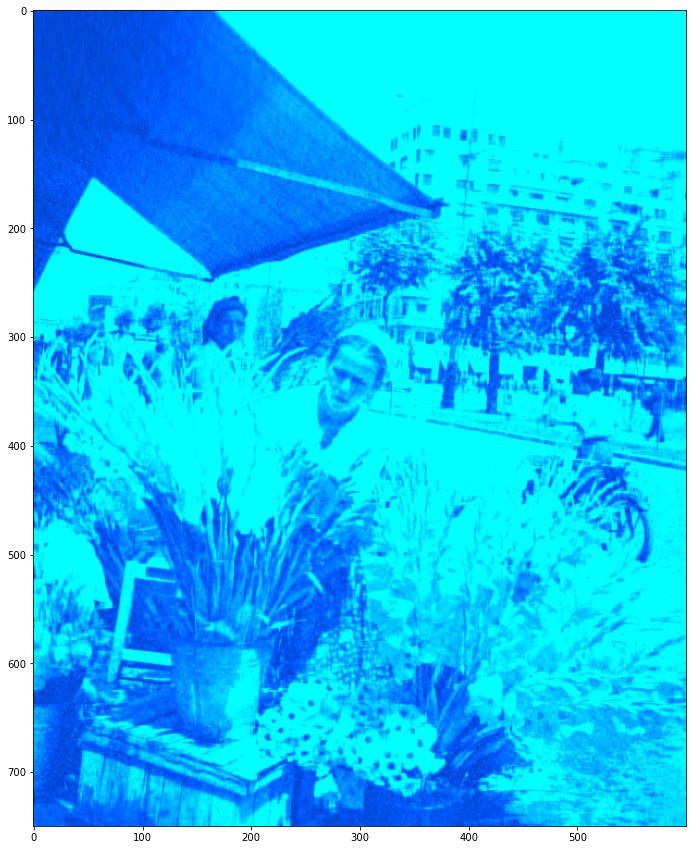

In [17]:
get_photo(image_pathway)